In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.datasets import cifar10, mnist
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adamifar10
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds

%matplotlib inline

In [5]:
# Consistent results
np.random.seed(10)

# The dimension of z
noise_dim = 100

batch_size = 128
steps_per_epoch = 64 


save_path = 'fcgan-images'

img_rows, img_cols, channels = 32, 32, 3

optimizer = Adam(0.0002, 0.5)

In [3]:
# Create path for saving images
if save_path != None and not os.path.isdir(save_path):
    os.mkdir(save_path)

In [4]:
#-- Load DS--
(train_examples), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'))

dataset = tfds.as_numpy(train_examples)

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


def resize(img):
  # img = tf.cast(img, tf.float32)
  img = tf.image.resize(img, (img_rows, img_cols))
  # img = tf.cast(img, tf.float32)
  # img = (img / 127.5) -1
  return img

x_train = np.zeros(shape=(8192,img_rows, img_cols,3))
i = 0 
for i,x in enumerate(dataset) :
  if i <8192:
    image = resize((x['image']))
    # print(image.shape)
    # print(image)
    # plt.imshow(image.reshape((img_rows, img_cols, channels)))
    # plt.show()
    x_train[i] = image

  i+=1
  if i >8192:
    break

# Normalize to between -1 and 1
x_train = (x_train.astype(np.float32) - 127.5) / 127.5


x_train = x_train.reshape(-1, img_rows*img_cols*channels)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteR7BWAU/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [6]:
x_train.shape

(8192, 3072)

In [7]:
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(2048, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator


def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(2048, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))


    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator


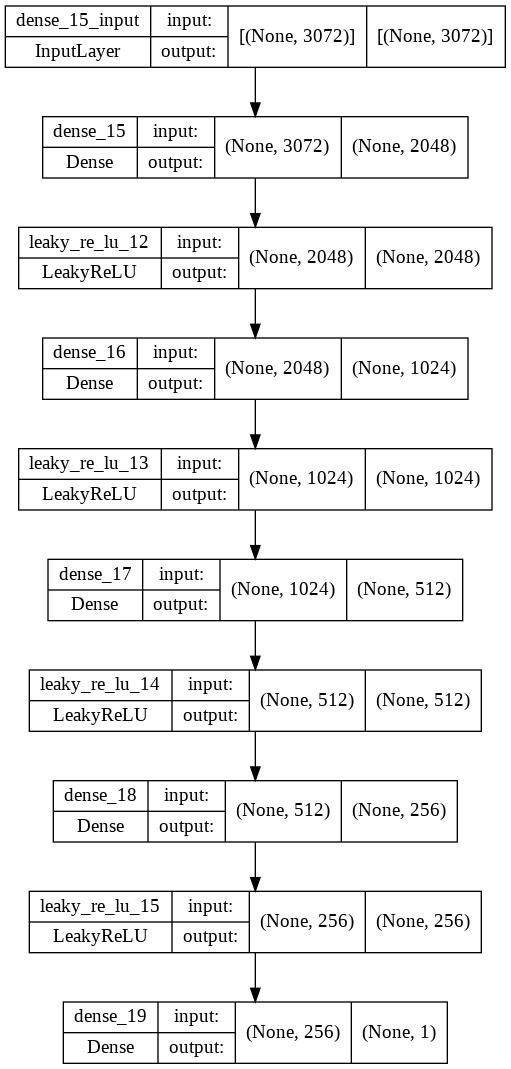

In [14]:
from tensorflow import keras
discriminator = create_descriminator()
keras.utils.plot_model(discriminator,show_shapes=True,expand_nested=True)

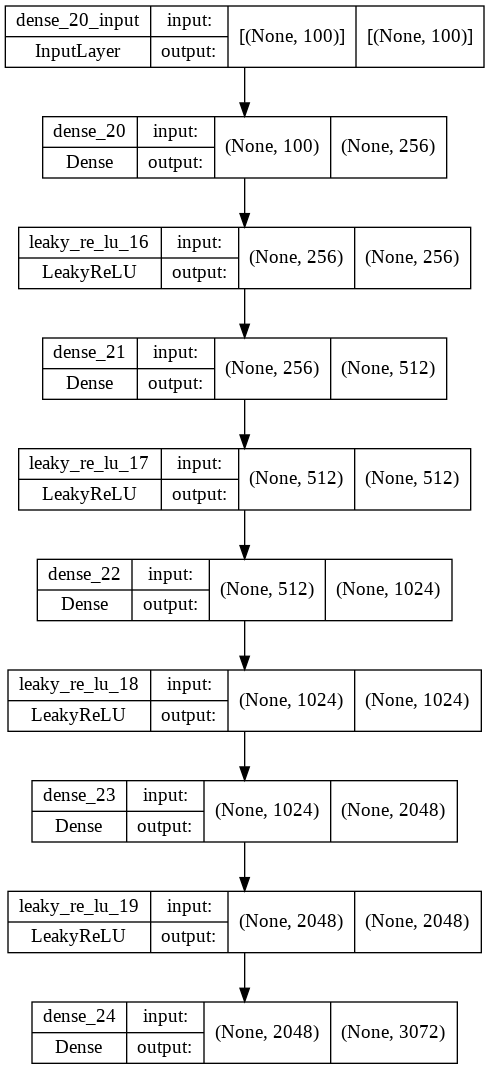

In [15]:
generator = create_generator()
keras.utils.plot_model(generator,show_shapes=True,expand_nested=True)

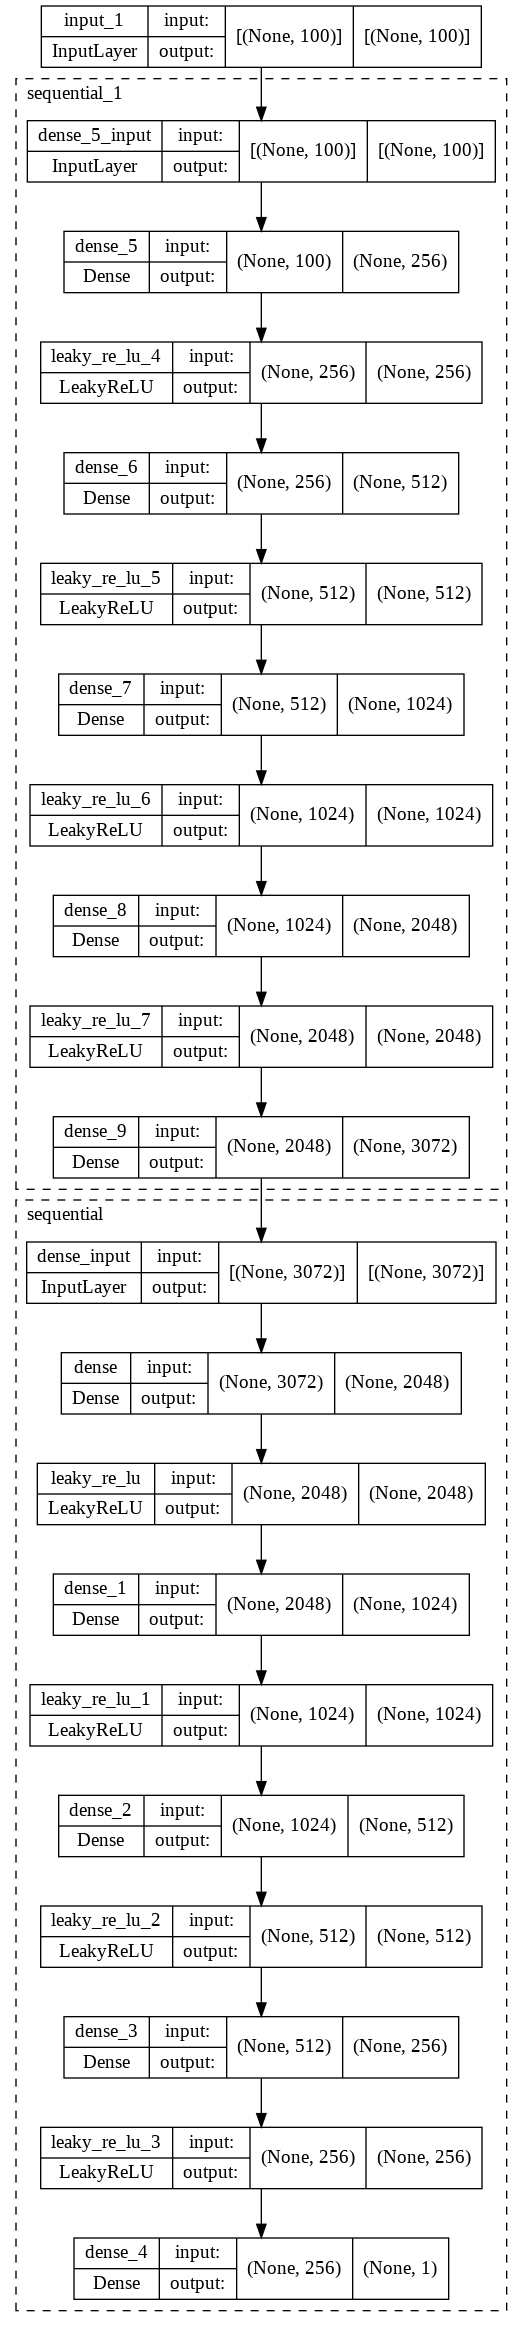

In [16]:
keras.utils.plot_model(gan,show_shapes=True,expand_nested=True)


In [8]:
discriminator = create_descriminator()
generator = create_generator()

# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
discriminator.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [11]:
# Display images, and save them if the epoch number is specified
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None and save_path != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()

In [9]:
#-- Plot Losses----------------------------------------------------------------
def Plot_Loss(d_losses, g_losses):
    
    d_losses = np.round(d_losses , 3)
    d_losses = np.round(d_losses , 3)
    
    x_plot = range(1, len(d_losses)+1)
    
    plt.figure(figsize=(7,4))
    
    plt.scatter(x=x_plot, y=d_losses)
    plt.plot(x_plot, d_losses , label= 'discriminator')
    
    plt.scatter(x=x_plot, y=g_losses)
    plt.plot(x_plot , g_losses, label = 'generator')
    
    
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.grid()
    plt.show()

Epoch: 0 	 Discriminator Loss: 0.6943254470825195 		 Generator Loss: 2.0608508586883545


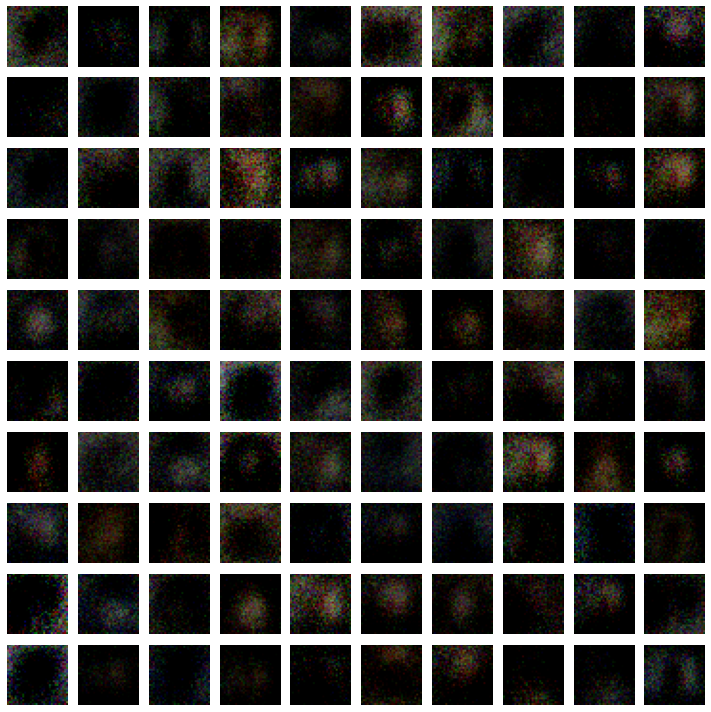

Epoch: 1 	 Discriminator Loss: 0.4418531656265259 		 Generator Loss: 2.1176540851593018
Epoch: 2 	 Discriminator Loss: 0.44043463468551636 		 Generator Loss: 1.9279401302337646
Epoch: 3 	 Discriminator Loss: 0.4221689999103546 		 Generator Loss: 2.549368143081665
Epoch: 4 	 Discriminator Loss: 0.6043963432312012 		 Generator Loss: 3.131122589111328
Epoch: 5 	 Discriminator Loss: 0.4096492826938629 		 Generator Loss: 2.347783088684082
Epoch: 6 	 Discriminator Loss: 0.445365309715271 		 Generator Loss: 2.3865737915039062
Epoch: 7 	 Discriminator Loss: 0.6211174726486206 		 Generator Loss: 1.9444172382354736
Epoch: 8 	 Discriminator Loss: 0.49252796173095703 		 Generator Loss: 2.042527914047241
Epoch: 9 	 Discriminator Loss: 0.4924842119216919 		 Generator Loss: 1.7408233880996704


Epoch: 10 	 Discriminator Loss: 0.4379333555698395 		 Generator Loss: 2.347773551940918


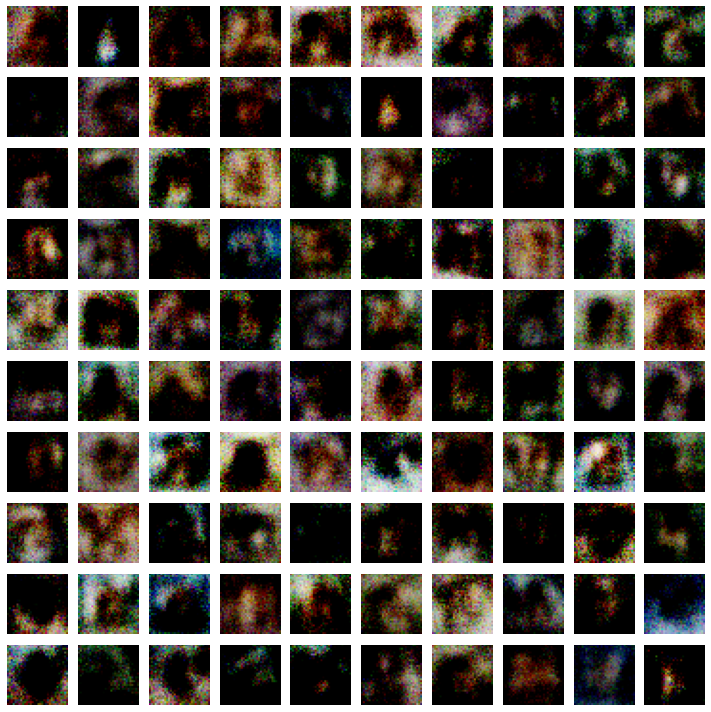

Epoch: 11 	 Discriminator Loss: 0.6311311721801758 		 Generator Loss: 2.7834956645965576
Epoch: 12 	 Discriminator Loss: 0.5802121162414551 		 Generator Loss: 1.8089890480041504
Epoch: 13 	 Discriminator Loss: 0.511613130569458 		 Generator Loss: 2.0091521739959717
Epoch: 14 	 Discriminator Loss: 0.5639716386795044 		 Generator Loss: 1.9054440259933472
Epoch: 15 	 Discriminator Loss: 0.523435652256012 		 Generator Loss: 2.264498233795166
Epoch: 16 	 Discriminator Loss: 0.5029659867286682 		 Generator Loss: 2.269913673400879
Epoch: 17 	 Discriminator Loss: 0.47961652278900146 		 Generator Loss: 1.881744623184204
Epoch: 18 	 Discriminator Loss: 0.46307235956192017 		 Generator Loss: 2.3275513648986816
Epoch: 19 	 Discriminator Loss: 0.5650221109390259 		 Generator Loss: 2.4669113159179688


Epoch: 20 	 Discriminator Loss: 0.5535814166069031 		 Generator Loss: 1.580723524093628


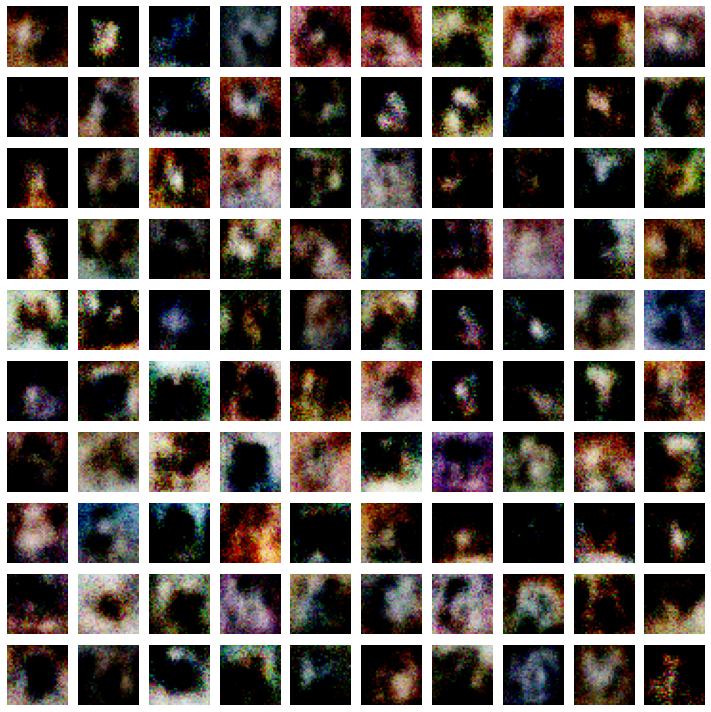

Epoch: 21 	 Discriminator Loss: 0.4820656478404999 		 Generator Loss: 2.4222373962402344
Epoch: 22 	 Discriminator Loss: 0.5580846667289734 		 Generator Loss: 1.6675374507904053
Epoch: 23 	 Discriminator Loss: 0.49344539642333984 		 Generator Loss: 1.9921854734420776
Epoch: 24 	 Discriminator Loss: 0.5039390921592712 		 Generator Loss: 1.9039740562438965
Epoch: 25 	 Discriminator Loss: 0.5428586602210999 		 Generator Loss: 1.6039457321166992
Epoch: 26 	 Discriminator Loss: 0.4978276491165161 		 Generator Loss: 2.153409004211426
Epoch: 27 	 Discriminator Loss: 0.49464377760887146 		 Generator Loss: 1.9050519466400146
Epoch: 28 	 Discriminator Loss: 0.5489479303359985 		 Generator Loss: 1.833829402923584
Epoch: 29 	 Discriminator Loss: 0.4485037624835968 		 Generator Loss: 2.366746664047241


Epoch: 30 	 Discriminator Loss: 0.49399203062057495 		 Generator Loss: 2.335397243499756


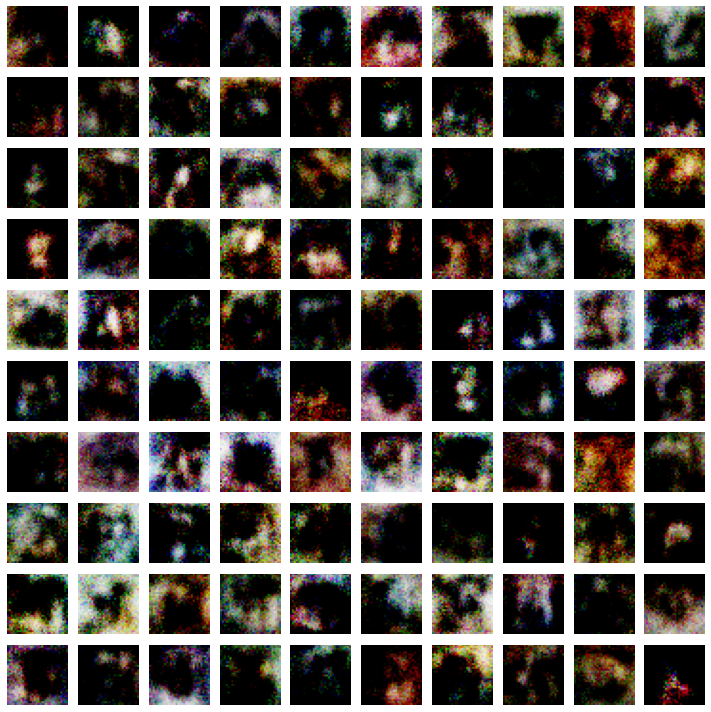

Epoch: 31 	 Discriminator Loss: 0.5350823998451233 		 Generator Loss: 1.8249297142028809
Epoch: 32 	 Discriminator Loss: 0.5137313604354858 		 Generator Loss: 2.215811014175415
Epoch: 33 	 Discriminator Loss: 0.49576500058174133 		 Generator Loss: 2.3289847373962402
Epoch: 34 	 Discriminator Loss: 0.4826934337615967 		 Generator Loss: 2.3661770820617676
Epoch: 35 	 Discriminator Loss: 0.5694301128387451 		 Generator Loss: 1.4883816242218018
Epoch: 36 	 Discriminator Loss: 0.49999696016311646 		 Generator Loss: 1.7718721628189087
Epoch: 37 	 Discriminator Loss: 0.504985511302948 		 Generator Loss: 2.008638620376587
Epoch: 38 	 Discriminator Loss: 0.5375154614448547 		 Generator Loss: 2.094500780105591
Epoch: 39 	 Discriminator Loss: 0.5174615979194641 		 Generator Loss: 1.8256219625473022


Epoch: 40 	 Discriminator Loss: 0.5339480042457581 		 Generator Loss: 1.9779489040374756


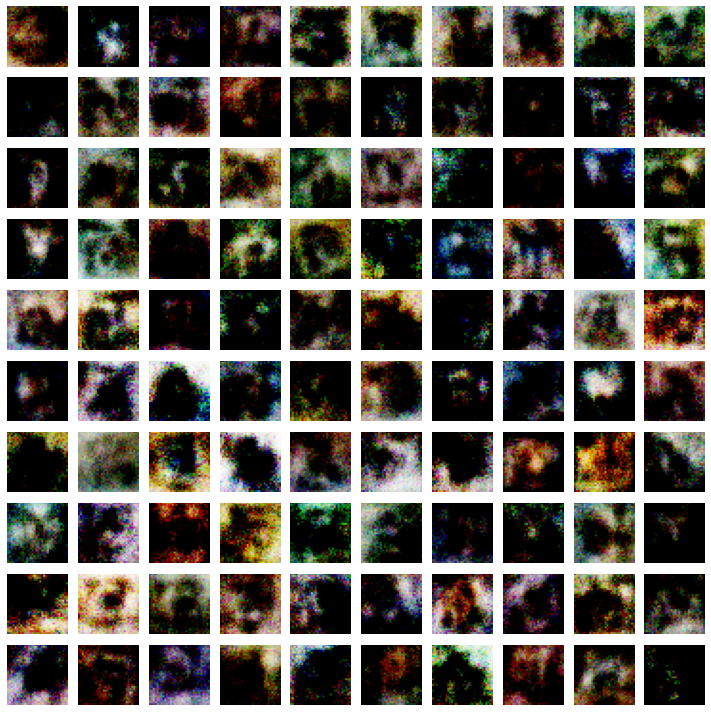

Epoch: 41 	 Discriminator Loss: 0.5163067579269409 		 Generator Loss: 1.864055871963501
Epoch: 42 	 Discriminator Loss: 0.5536556839942932 		 Generator Loss: 2.5568833351135254
Epoch: 43 	 Discriminator Loss: 0.555696964263916 		 Generator Loss: 1.55037522315979
Epoch: 44 	 Discriminator Loss: 0.5074138641357422 		 Generator Loss: 1.792172908782959
Epoch: 45 	 Discriminator Loss: 0.5467990636825562 		 Generator Loss: 2.151949644088745
Epoch: 46 	 Discriminator Loss: 0.4782346785068512 		 Generator Loss: 2.4783928394317627
Epoch: 47 	 Discriminator Loss: 0.5520976781845093 		 Generator Loss: 2.423511505126953
Epoch: 48 	 Discriminator Loss: 0.535438060760498 		 Generator Loss: 1.994481086730957
Epoch: 49 	 Discriminator Loss: 0.4992483854293823 		 Generator Loss: 2.0108463764190674


Epoch: 50 	 Discriminator Loss: 0.5605487823486328 		 Generator Loss: 1.7787015438079834


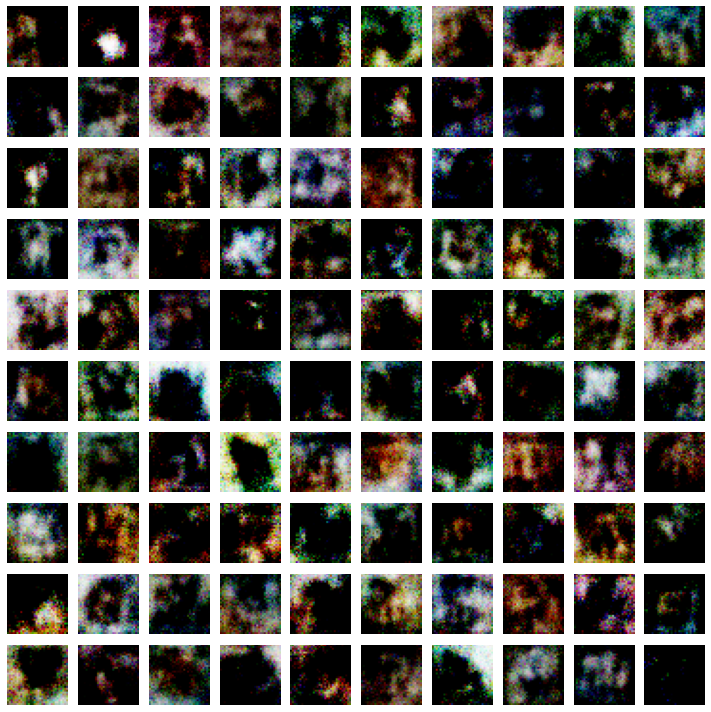

Epoch: 51 	 Discriminator Loss: 0.5964218974113464 		 Generator Loss: 1.766469955444336
Epoch: 52 	 Discriminator Loss: 0.5074610114097595 		 Generator Loss: 1.891161561012268
Epoch: 53 	 Discriminator Loss: 0.5270715951919556 		 Generator Loss: 2.3310208320617676
Epoch: 54 	 Discriminator Loss: 0.541390061378479 		 Generator Loss: 1.7870674133300781
Epoch: 55 	 Discriminator Loss: 0.5247628688812256 		 Generator Loss: 2.258570671081543
Epoch: 56 	 Discriminator Loss: 0.48653486371040344 		 Generator Loss: 1.9325811862945557
Epoch: 57 	 Discriminator Loss: 0.521278977394104 		 Generator Loss: 1.8796087503433228
Epoch: 58 	 Discriminator Loss: 0.5069639086723328 		 Generator Loss: 1.8683867454528809
Epoch: 59 	 Discriminator Loss: 0.5517396926879883 		 Generator Loss: 2.107353687286377


Epoch: 60 	 Discriminator Loss: 0.5518079996109009 		 Generator Loss: 1.7679615020751953


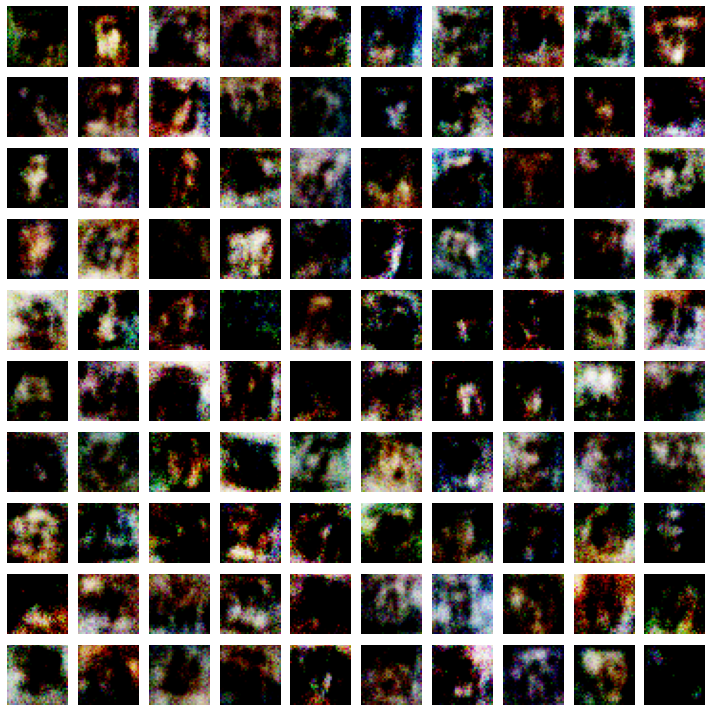

Epoch: 61 	 Discriminator Loss: 0.537555992603302 		 Generator Loss: 1.8392902612686157
Epoch: 62 	 Discriminator Loss: 0.49949201941490173 		 Generator Loss: 2.0770413875579834
Epoch: 63 	 Discriminator Loss: 0.5305351614952087 		 Generator Loss: 1.8220491409301758
Epoch: 64 	 Discriminator Loss: 0.6046808958053589 		 Generator Loss: 2.6293444633483887
Epoch: 65 	 Discriminator Loss: 0.5128505825996399 		 Generator Loss: 2.186025619506836
Epoch: 66 	 Discriminator Loss: 0.6310784816741943 		 Generator Loss: 2.4441323280334473
Epoch: 67 	 Discriminator Loss: 0.5286473035812378 		 Generator Loss: 2.170163631439209
Epoch: 68 	 Discriminator Loss: 0.5012027621269226 		 Generator Loss: 2.1413345336914062
Epoch: 69 	 Discriminator Loss: 0.5560766458511353 		 Generator Loss: 1.748326301574707


Epoch: 70 	 Discriminator Loss: 0.574959933757782 		 Generator Loss: 1.7220463752746582


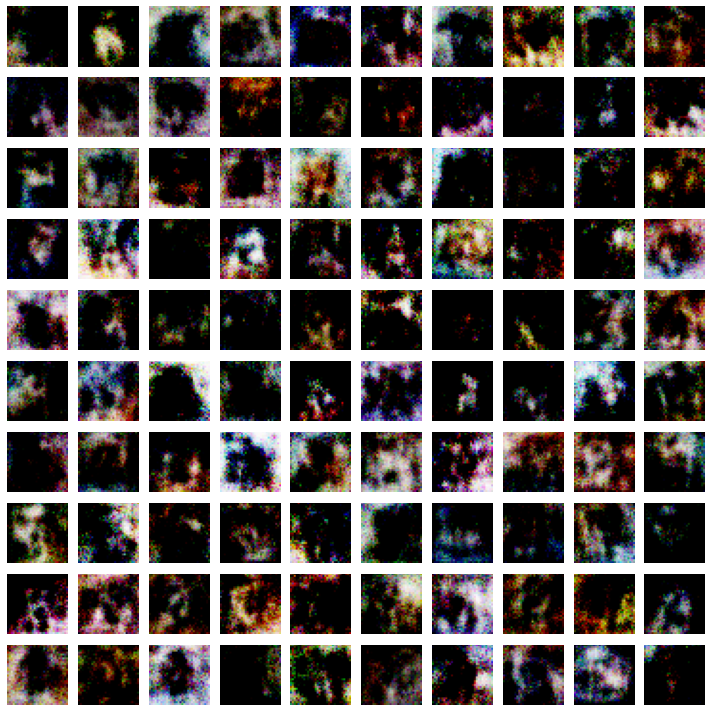

Epoch: 71 	 Discriminator Loss: 0.5207306742668152 		 Generator Loss: 1.92640221118927
Epoch: 72 	 Discriminator Loss: 0.5431292057037354 		 Generator Loss: 1.9373455047607422
Epoch: 73 	 Discriminator Loss: 0.5317428708076477 		 Generator Loss: 1.734631896018982
Epoch: 74 	 Discriminator Loss: 0.5503475666046143 		 Generator Loss: 2.126286506652832
Epoch: 75 	 Discriminator Loss: 0.4918923079967499 		 Generator Loss: 1.9225356578826904
Epoch: 76 	 Discriminator Loss: 0.5496258735656738 		 Generator Loss: 1.8963314294815063
Epoch: 77 	 Discriminator Loss: 0.5349368453025818 		 Generator Loss: 1.842511534690857
Epoch: 78 	 Discriminator Loss: 0.573517918586731 		 Generator Loss: 2.347968578338623
Epoch: 79 	 Discriminator Loss: 0.543032169342041 		 Generator Loss: 1.8984295129776


Epoch: 80 	 Discriminator Loss: 0.5485765933990479 		 Generator Loss: 1.9635930061340332


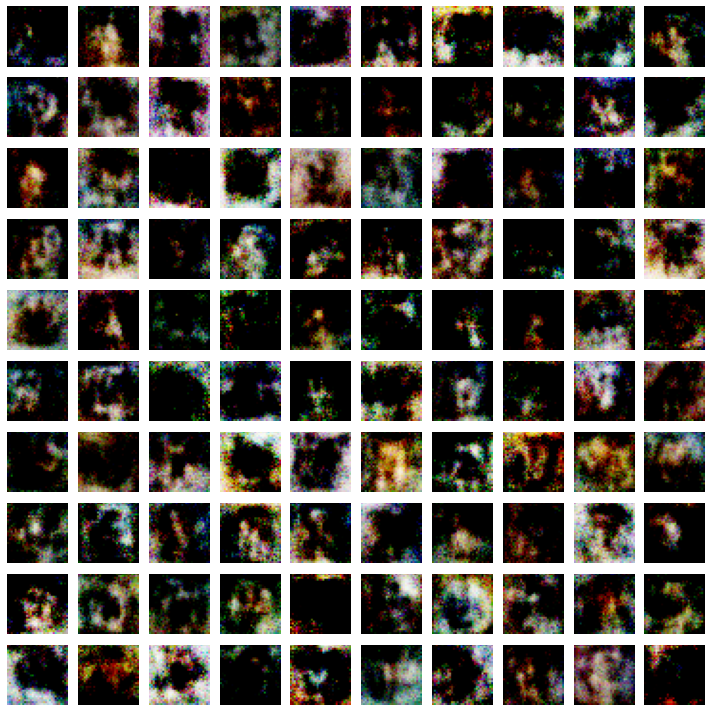

Epoch: 81 	 Discriminator Loss: 0.5279564261436462 		 Generator Loss: 2.559546709060669
Epoch: 82 	 Discriminator Loss: 0.4882126450538635 		 Generator Loss: 2.021242618560791
Epoch: 83 	 Discriminator Loss: 0.5089944005012512 		 Generator Loss: 2.0087223052978516
Epoch: 84 	 Discriminator Loss: 0.5224059224128723 		 Generator Loss: 1.9943068027496338
Epoch: 85 	 Discriminator Loss: 0.6282870769500732 		 Generator Loss: 1.9202998876571655
Epoch: 86 	 Discriminator Loss: 0.496005654335022 		 Generator Loss: 1.9322054386138916
Epoch: 87 	 Discriminator Loss: 0.504313051700592 		 Generator Loss: 2.448711633682251
Epoch: 88 	 Discriminator Loss: 0.5011399388313293 		 Generator Loss: 1.745723843574524
Epoch: 89 	 Discriminator Loss: 0.49221712350845337 		 Generator Loss: 2.0873537063598633


Epoch: 90 	 Discriminator Loss: 0.5401623249053955 		 Generator Loss: 2.170862913131714


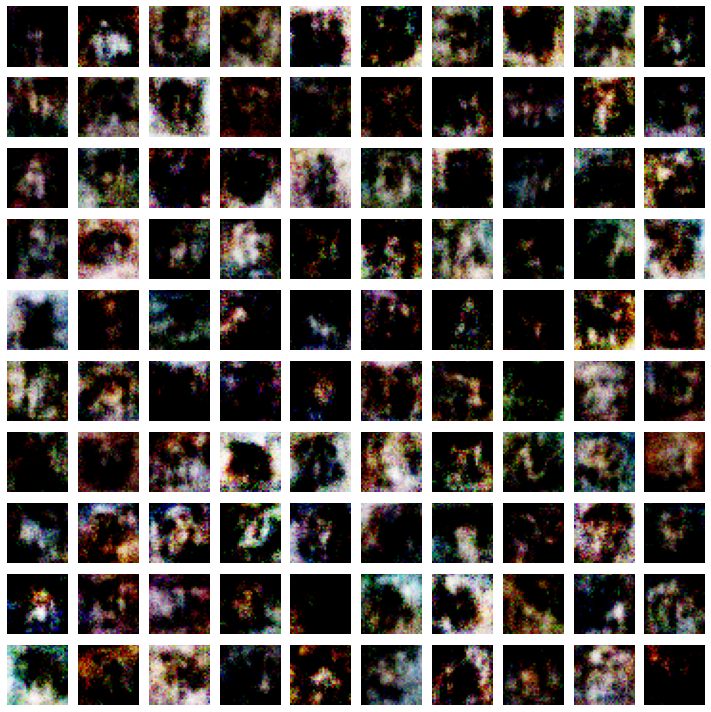

Epoch: 91 	 Discriminator Loss: 0.5250624418258667 		 Generator Loss: 2.2061192989349365
Epoch: 92 	 Discriminator Loss: 0.5382408499717712 		 Generator Loss: 1.9082967042922974
Epoch: 93 	 Discriminator Loss: 0.5234348177909851 		 Generator Loss: 1.8161929845809937
Epoch: 94 	 Discriminator Loss: 0.5477254986763 		 Generator Loss: 2.0577306747436523
Epoch: 95 	 Discriminator Loss: 0.541824460029602 		 Generator Loss: 1.9499425888061523
Epoch: 96 	 Discriminator Loss: 0.5291464924812317 		 Generator Loss: 1.9478071928024292
Epoch: 97 	 Discriminator Loss: 0.5008478164672852 		 Generator Loss: 2.034578323364258
Epoch: 98 	 Discriminator Loss: 0.4892210364341736 		 Generator Loss: 1.8629693984985352
Epoch: 99 	 Discriminator Loss: 0.5643019676208496 		 Generator Loss: 2.099459409713745


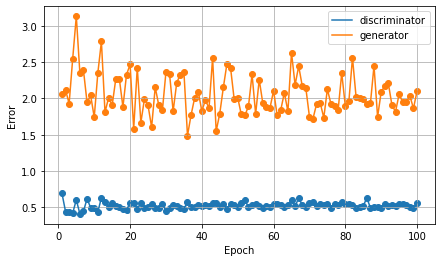

In [12]:
#-- Train --
d_losses = []
g_losses = []

epochs = 100

# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, noise_dim))

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    d_losses.append(d_loss)
    g_losses.append(g_loss)
    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    if epoch % 10 == 0:
        show_images(static_noise, epoch)
        
Plot_Loss(d_losses, g_losses)

In [17]:
a=4